# Import dataset

In [1]:
import tensorflow as tf
tf.random.set_seed(10)
import random
random.seed(10)
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
# from PIL import Image, ImageEnhance

In [2]:
data_dir = 'dataset/'
img_height = 72
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + 'train/',
  seed=128,
  image_size=(img_height, img_width))

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + 'validation/',
  seed=128,
  image_size=(img_height, img_width))

# train_dataset = []
# for i in range(180):
#     train_dataset.append(tf.keras.utils.image_dataset_from_directory(
#     f'dataset/train_{i}/',
#     seed=128,
#     image_size=(img_height, img_width)))

pretrain_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir + 'pretrain/',
  seed=123,
  image_size=(img_height, img_width))

def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
pretrain_ds = train_ds.map(normalize)
# for i in range(180):
#     train_dataset[i] = train_dataset[i].map(normalize)

Found 36000 files belonging to 4 classes.
Found 4000 files belonging to 4 classes.
Found 16200 files belonging to 4 classes.


# Pretrain CNN model

In [3]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(72, 128, 3)),
    tf.keras.layers.Conv2D(16, (11, 11), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (9, 9), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# model.summary()

In [7]:
pretrain_history = model.fit(pretrain_ds, epochs=10, batch_size=32)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.6686 - loss: 0.7117
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.8847 - loss: 0.2900
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9269 - loss: 0.1963
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9506 - loss: 0.1397
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9623 - loss: 0.1070
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9702 - loss: 0.0886
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9748 - loss: 0.0756
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9792 - loss: 0.0636
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9807 - loss: 0.0607
Epoch 10/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.9838 - loss: 0.0480


dict_keys(['accuracy', 'loss'])


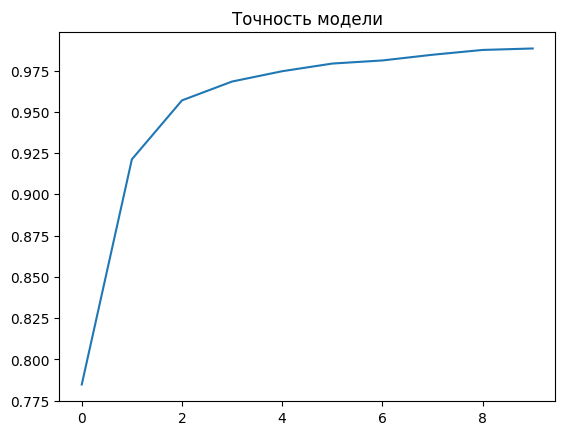

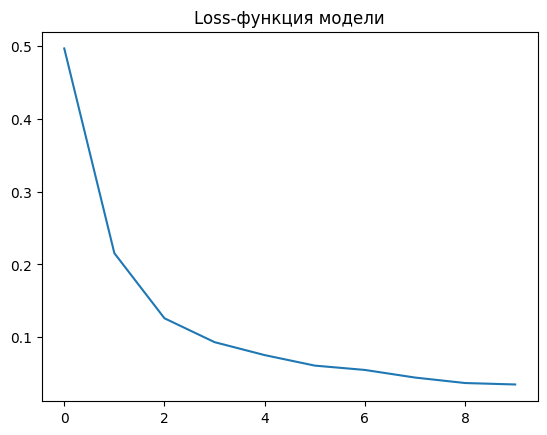

In [14]:
# print(pretrain_history.history.keys())
plt.plot(pretrain_history.history['accuracy'])
plt.title('Точность модели')
plt.show()
plt.plot(pretrain_history.history['loss'])
plt.title('Loss-функция модели')
plt.show()

In [6]:
model.save_weights('./weights/pretrained_weights.weights.h5')

In [4]:
model.load_weights('./weights/pretrained_weights.weights.h5')

C:\Users\SlothMaster\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
val_loss, val_acc = model.evaluate(val_ds)
print('Accuracy on pretrained model:', val_acc)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6778 - loss: 296.8544
Accuracy on pretrained model: 0.6754999756813049


# Fine-tuning by optimizers

In [7]:
# for i in range(7):
#     model.layers[i].trainable = False

optimizers = ['adam', 'sgd', 'lion', 'loss_scale_optimizer']

for i in range(len(optimizers)):
    model.load_weights('./weights/pretrained_weights.weights.h5')
    model.optimizer = optimizers[i]
    # model.summary()
    # for i in range(7):
    #     model.layers[i].trainable = False
    history = model.fit(train_ds, epochs=1, batch_size=32)
    # plt.plot(history.history['accuracy'])
    # plt.title('Точность модели')
    # plt.show()
    # plt.plot(pretrain_history.history['loss'])
    # plt.title('Loss-функция модели')
    # plt.show()
    # model.save_weights('./weights/' + optimizers[i] + '.weights.h5')
    val_loss, val_acc = model.evaluate(val_ds)
    print('Accuracy on model fine-tuned by optimizer ' + optimizers[i] + ':', val_acc)

AttributeError: 'str' object has no attribute 'scale_loss'

# Fine-tuning by GA

In [11]:
def weights_to_list(weights):
    plist = []
    for i in range(32):
        plist.extend(weights[8][i])
    plist.extend(weights[9])
    return plist

def list_to_weights(weights):
    for i in range(32):
        arr = []
        for j in range(4):
            arr.append(weights[i * 4 + j])
        pretrained_weights[8][i] = np.array(arr, dtype="float32")
    pretrained_weights[9] = np.array(weights[-4:], dtype="float32")
    return pretrained_weights

In [23]:
random.seed(32)

def accuracy(w):
    model.set_weights(list_to_weights(w))
    test_loss, test_accuracy = model.evaluate(train_ds, verbose=None)
    return test_accuracy

def random_method(first_individual, population_size):
    population = []
    for i in range(population_size):
        individual = deepcopy(first_individual)
        if i != 0:
            for j in range(len(first_individual)):
                if random.random() < 75 / len(first_individual):
                    individual[j] += 0.5 * random.random() - 0.25
        population.append(individual)
    best_ind = -1
    max_acc = 0
    for i in tqdm(range(population_size)):
        acc = accuracy(population[i])
        if acc > max_acc:
            max_acc = acc
            best_ind = i
    return population[best_ind]

In [24]:
model.load_weights('./weights/pretrained_weights.weights.h5')
pretrained_weights = model.get_weights()

best_ind = random_method(weights_to_list(pretrained_weights), 150)

model.set_weights(list_to_weights(best_ind))

val_loss, val_acc = model.evaluate(val_ds)
print('Accuracy on test dataset:', val_acc)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [26:52<00:00, 10.75s/it]

 16/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7880 - loss: 234.3019

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7691 - loss: 236.0352
Accuracy on test dataset: 0.7620000243186951


In [25]:
model.save_weights('./weights/random.weights.h5')

In [6]:
random.seed(32)

def accuracy(w):
    model.set_weights(list_to_weights(w))
    # test_loss, test_accuracy1 = model.evaluate(train_dataset[random.randint(0, 179)], verbose=None)
    # test_loss, test_accuracy2 = model.evaluate(train_dataset[random.randint(0, 179)], verbose=None)
    # test_loss, test_accuracy3 = model.evaluate(train_dataset[random.randint(0, 179)], verbose=None)
    # test_loss, test_accuracy4 = model.evaluate(train_dataset[random.randint(0, 179)], verbose=None)
    # test_loss, test_accuracy5 = model.evaluate(train_dataset[random.randint(0, 179)], verbose=None)
    # return (test_accuracy1 + test_accuracy2 + test_accuracy3 + test_accuracy4 + test_accuracy5) / 5
    test_loss, test_accuracy = model.evaluate(train_ds, verbose=None)
    return test_accuracy

def genetic_algorithm(first_individual, population_size, n_iterations, silent = False):

    P_CROSSOVER = 0.9
    P_MUTATION = 0.3
    ELITE = 2
    T = 0.4

    population = []
    max_fit = []
    avg_fit = []

    for i in range(population_size):
        individual = deepcopy(first_individual)
        if i != 0:
            for j in range(len(first_individual)):
                if random.random() < 75 / len(first_individual):
                    individual[j] += 0.5 * random.random() - 0.25
        population.append(individual)

    with tqdm(total=n_iterations, disable = silent) as pbar:
        for k in range(n_iterations):
            population = sorted(population, key=lambda x: -accuracy(x))
            max_fit.append(accuracy(population[0]))

            offsprings = []
            offsprings.extend(population[:ELITE])
            for i in range(ELITE, population_size):
                r = random.randint(0, round(T * population_size))
                offsprings.append(deepcopy(population[r]))

            for i in range(ELITE, population_size // 2 + ELITE // 2):
                if random.random() < P_CROSSOVER:
                    parent1 = offsprings[i]
                    parent2 = offsprings[i + population_size // 2 - ELITE // 2]
                    for gene in range(len(parent1)):
                        if random.random() < 0.5:
                            parent1[gene], parent2[gene] = parent2[gene], parent1[gene]

            for i in range(ELITE, population_size):
                if random.random() < P_MUTATION:
                    for gene in range(len(offsprings[i])):
                        if random.random() < 0.1:
                            if gene < 128:
                                offsprings[i][gene] = 0.5 * random.random() - 0.25
                            else:
                                offsprings[i][gene] = 5 * random.random() - 2.5
            population = offsprings
            pbar.update(1)
    population = sorted(population, key=lambda x: -accuracy(x))
    return population[0], max_fit

C:\Users\SlothMaster\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
100%|████████████████████████████████████████████████████████████████████████████| 120/120 [10:15:48<00:00, 307.91s/it]


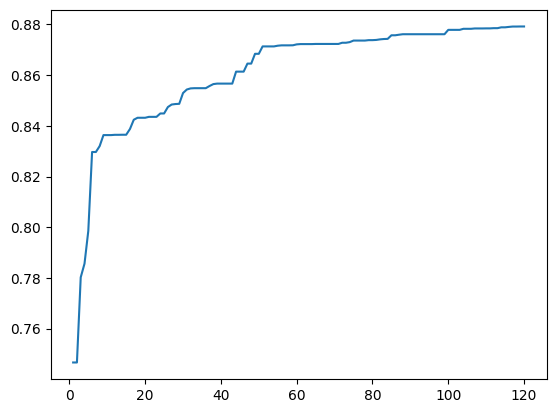

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8752 - loss: 67.7286
Accuracy on test dataset: 0.8794999718666077


In [7]:
model.load_weights('./weights/pretrained_weights.weights.h5')
pretrained_weights = model.get_weights()

best_ind, max_fit = genetic_algorithm(weights_to_list(pretrained_weights), 30, 120)

t = list(range(1, len(max_fit) + 1))
plt.plot(t, max_fit)
plt.show()

model.set_weights(list_to_weights(best_ind))

val_loss, val_acc = model.evaluate(val_ds)
print('Accuracy on test dataset:', val_acc)

In [8]:
model.save_weights('./weights/ga.weights.h5')

In [27]:
tf.config.run_functions_eagerly(True)

from tensorflow.python.framework import tensor_conversion
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend

model = tf.keras.Sequential([
    tf.keras.Input(shape=(72, 128, 3)),
    tf.keras.layers.Conv2D(16, (11, 11), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (9, 9), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

def accuracy1(y_true, y_pred):
    y_pred = tensor_conversion.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = tensor_conversion.convert_to_tensor_v2_with_dispatch(y_true)
    y_pred_rank = y_pred.shape.ndims
    y_true_rank = y_true.shape.ndims
    if (y_true_rank is not None) and (y_pred_rank is not None) and (len(backend.int_shape(y_true)) == len(backend.int_shape(y_pred))):
        y_true = array_ops.squeeze(y_true, [-1])
    y_pred = math_ops.argmax(y_pred, axis=-1)
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))
    
    return math_ops.cast(math_ops.equal(y_true, y_pred), backend.floatx())

def prediction_metrics(y_true, y_pred):
    y_pred = tensor_conversion.convert_to_tensor_v2_with_dispatch(y_pred)
    y_true = tensor_conversion.convert_to_tensor_v2_with_dispatch(y_true)
    y_pred_rank = y_pred.shape.ndims
    y_true_rank = y_true.shape.ndims
    if (y_true_rank is not None) and (y_pred_rank is not None) and (len(backend.int_shape(y_true)) == len(backend.int_shape(y_pred))):
        y_true = array_ops.squeeze(y_true, [-1])
    y_pred = math_ops.argmax(y_pred, axis=-1)
    if backend.dtype(y_pred) != backend.dtype(y_true):
        y_pred = math_ops.cast(y_pred, backend.dtype(y_true))

    y_true = y_true.numpy().tolist()
    y_pred = y_pred.numpy().tolist()
    metrics = []
    for cl in range(4):
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(len(y_true)):
            if y_pred[i] == cl:
                if y_pred[i] == y_true[i]:
                    tp += 1
                else:
                    fp += 1
            else:
                if y_pred[i] == y_true[i]:
                    tn += 1
                else:
                    fn += 1
        metrics.append([tp, fp, tn, fn])
    return metrics

def accuracy_(y_true, y_pred):
    p_metrics = prediction_metrics(y_true, y_pred)
    results = []
    for metrics in p_metrics:
        tp, fp, tn, fn = metrics
        results.append((tp + tn) / (tp + tn + fp + fn))
    return sum(results) / len(results)

def f1_score(y_true, y_pred):
    p_metrics = prediction_metrics(y_true, y_pred)
    results = []
    for metrics in p_metrics:
        tp, fp, tn, fn = metrics
        if tp != 0:
            pr = tp / (tp + fp)
        else:
            pr = 0
        if tp != 0:
            re = tp / (tp + fn)
        else:
            re = 0
        if pr + re != 0:
            f1 = 2 * pr * re / (pr + re)
        else:
            f1 = 0
        results.append(f1)
    return sum(results) / len(results)

def recall(y_true, y_pred):
    p_metrics = prediction_metrics(y_true, y_pred)
    results = []
    for metrics in p_metrics:
        tp, fp, tn, fn = metrics
        if tp != 0:
            re = tp / (tp + fn)
        else:
            re = 0
        results.append(re)
    return sum(results) / len(results)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', accuracy_, f1_score, recall])

In [28]:
weights_labels = ['pretrained_weights', 'random', 'ais', 'ga', 'adam', 'sgd', 'lion']

for label in weights_labels:
    model.load_weights(f'./weights/{label}.weights.h5')
    val_loss, *val_metrics = model.evaluate(val_ds, verbose=None)
    print(label, 'Точность', round(val_metrics[1], 4), 'F-мера', round(val_metrics[2], 4), 'Полнота', round(val_metrics[3], 4))

pretrained_weights Точность 0.721 F-мера 0.5443 Полнота 0.479
random Точность 0.762 F-мера 0.6038 Полнота 0.5305
ais Точность 0.8665 F-мера 0.7521 Полнота 0.6869
ga Точность 0.8795 F-мера 0.7724 Полнота 0.7114
adam Точность 0.9668 F-мера 0.932 Полнота 0.9088
sgd Точность 0.9485 F-мера 0.8961 Полнота 0.8621
lion Точность 0.9697 F-мера 0.9377 Полнота 0.9145


In [17]:
model.load_weights(f'./weights/{weights_labels[0]}.weights.h5')
w1 = model.get_weights()
model.load_weights(f'./weights/{weights_labels[6]}.weights.h5')
w2 = model.get_weights()

In [18]:
print(w1[0][0][0], w2[0][0][0])

[[ 6.94455951e-02 -4.82235774e-02  3.88446786e-02 -3.27436952e-03
   3.13381315e-05  2.52631251e-02 -8.28768015e-02 -3.43448594e-02
  -2.56512035e-02  5.10740131e-02  9.98380855e-02  4.74690869e-02
  -1.90245941e-01 -2.66435519e-02  1.57391448e-02 -6.30109832e-02]
 [-1.57778814e-01 -2.42206492e-02  2.02270281e-02  2.64043063e-02
   3.66465077e-02 -2.57718433e-02 -1.09006301e-01  2.80152564e-03
  -3.23886238e-02 -2.63757229e-01  1.09505266e-01  8.06771219e-03
   3.03600784e-02 -4.77041565e-02  1.85972467e-01 -2.13878497e-01]
 [ 1.35080606e-01  4.46693599e-02 -2.60634497e-02 -2.12517101e-02
  -3.89017761e-02 -1.33715542e-02  3.11140388e-01  3.33478451e-02
  -2.73680687e-02  9.57634524e-02  1.81285754e-01 -2.85925921e-02
  -3.29601228e-01  2.24123616e-03  1.31539941e-01  1.23534344e-01]] [[ 0.0705457  -0.05482604  0.08845679 -0.00476242 -0.02874912  0.01918628
  -0.04803075 -0.07170922 -0.04647748  0.06000023  0.01816974 -0.02216909
  -0.2022145  -0.05077853 -0.05261144 -0.03160958]
 [-0.